In [1]:
############ LOAD in custom packages ################
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import importlib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import LinearSVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, make_scorer, confusion_matrix, mean_squared_error, mean_absolute_error

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier

from scipy.stats import randint, uniform



# Get the absolute path of the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
# Define data directory
brighten_dir = os.path.join(project_root, 'BRIGHTEN_data')

# Add project root to sys.path
sys.path.append(project_root)

# Import and reload custom scripts
from scripts import preprocessing as pre
from scripts import visualization as vis
from scripts import feature_selection as fs
from scripts import clustering as cl
from scripts import modeling as mod
importlib.reload(pre)
importlib.reload(vis)
importlib.reload(fs)
importlib.reload(cl)
importlib.reload(mod)

# ### Load in packages and variables


################ DEFINE column variables from data ###################
from scripts.variables import id_columns, daily_cols_v1, daily_v2_common 
from scripts.variables import phq2_cols, phq9_cols, weekly_cols, passive_cols, survey_cols


## Load in dfs scaled
df_names = ['v1_day', 'v2_day', 'v1_week', 'v2_week']

dfs_pca = {}
for name in df_names:
    dfs_pca[name] = pd.read_csv(os.path.join(brighten_dir, f'{name}_pca.csv'))

dfs_scaled = {}
for name in df_names:
    dfs_scaled[name] = pd.read_csv(os.path.join(brighten_dir, f'{name}_scaled.csv'))


### 5. Model Selection - Classfication

We'll start by using several of the most popular classifiers with default parameters and compare how well they perform to indentify which might be best to proceed with.


In [ ]:

# Define the classifiers to test
clfs = [
    ('Logistic Regression', LogisticRegression(solver='liblinear', max_iter=2000)),
    ('KNN', KNeighborsClassifier()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('Linear SVM', LinearSVC(random_state=42, max_iter=1000, dual='auto')),
    ('XGBoost', XGBClassifier(random_state=42)),
    ('AdaBoost', AdaBoostClassifier(random_state=42, algorithm='SAMME')),
    ('Gradient Boost', GradientBoostingClassifier(random_state=42)),
    ('Bagging', BaggingClassifier(random_state=42)),
    ('CatBoost', CatBoostClassifier(random_state=42, verbose=0)),
]



We'll use cross-validation to get a better understanding of each models performance, rather than just a single test. Let's create a KFold object so we can use the same folds for each classifier.

Let's now plot the results of each test, for each classifyer with a boxplot so we can compare the models.

In [ ]:
# Plot scores
fig, ax = plt.subplots(figsize=(14, 8))
sns.boxplot(cv_scores_df)

# Add axis labels
ax.set_xlabel('Classifier', fontsize=12)
ax.set_ylabel('CV Accuracy Score', fontsize=12)
ax.set_title('Cross-Validation Scores for Different Classifiers', fontsize=14)




From the table, we can see the best performing model was CatBoost, followed by Gradient Boost. The worst performing model was the Descision Tree.

Although the CatBoost and Gradient Boost models performed better, I'll proceed for now with the XGBoost model, as hyperparameter tuning is much faster.

### 6. Feature Engineering

Let's take a look at the distributions of our numerical features to see if we could potentially improve the performance of our models by transforming any existing features. First we'll create histograms for each of the numerical features.


In [ ]:
# Melt the DataFrame to long format
melted_X_train = X_train_cleaned[numerical_cols].melt(var_name='Column', value_name='Value')

# Create a FacetGrid
g = sns.FacetGrid(melted_X_train, col='Column', col_wrap=4, sharex=False, sharey=False, height=4)

# Map the sns.histplot to each facet
g.map(sns.histplot, 'Value', bins=25)

# Add titles and labels
g.set_axis_labels('Value', 'Frequency')
g.set_titles(col_template='{col_name}')

plt.tight_layout()
plt.show()


In [ ]:
# Create KFold object with 10 folds
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Dictionary to store results
results = {}

# Evaluate each classifier using cross-validation
for clf_name, clf in clfs:
    cv_scores = cross_val_score(clf, X_train_cleaned, y_train, cv=kf)
    results[clf_name] = cv_scores

cv_scores_df = pd.DataFrame(results)

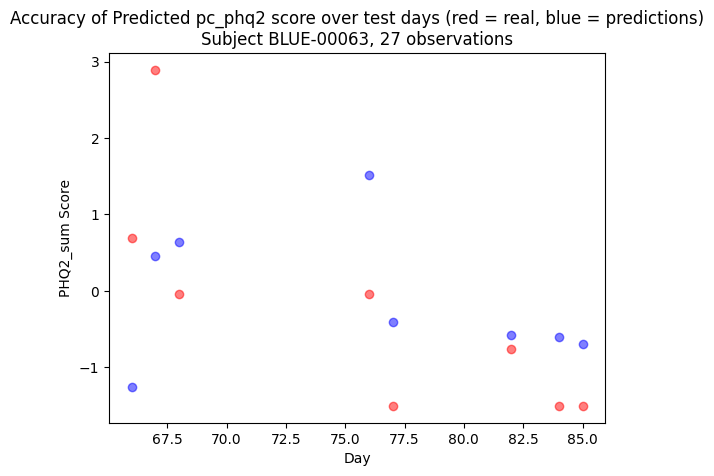

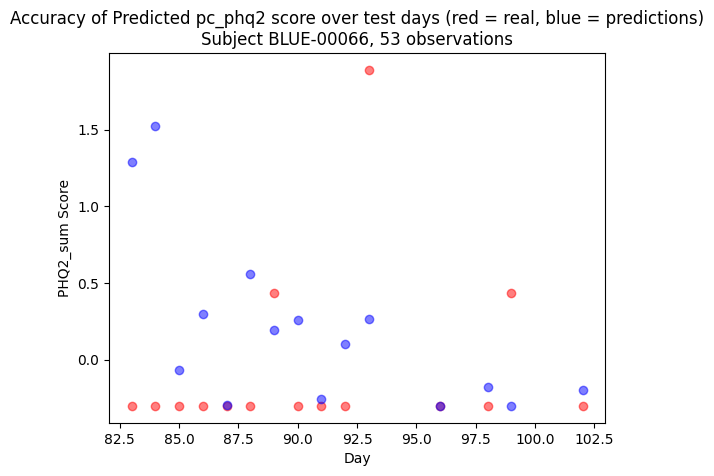

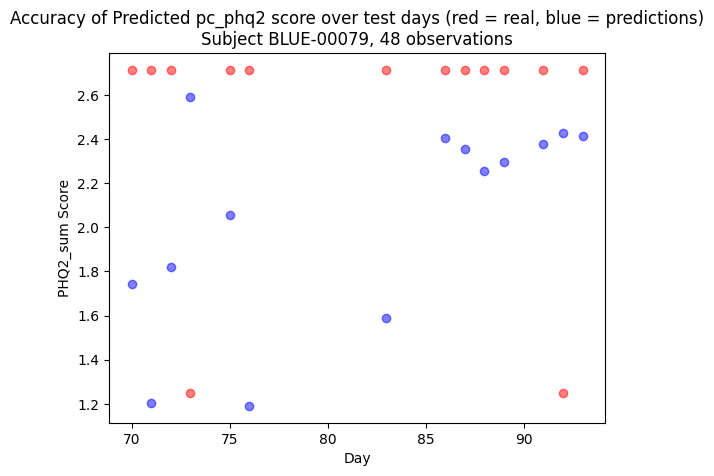

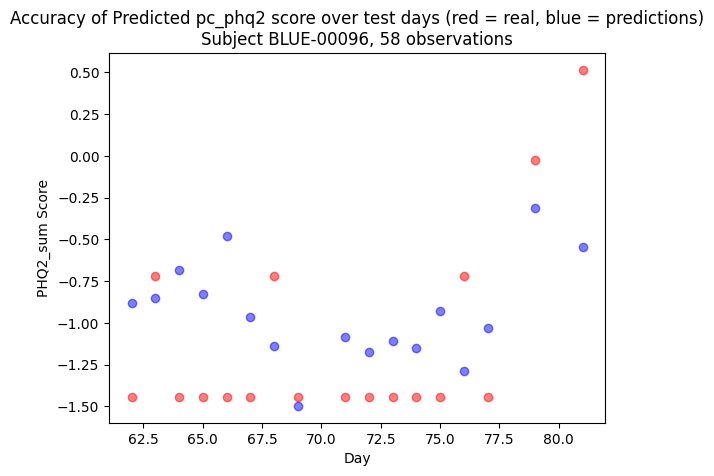

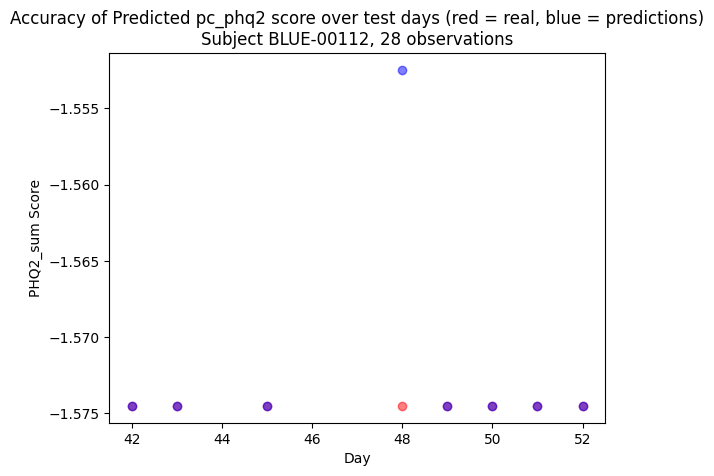

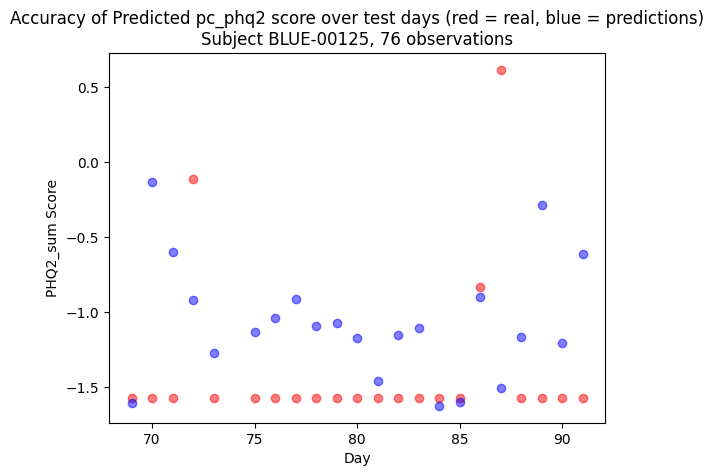

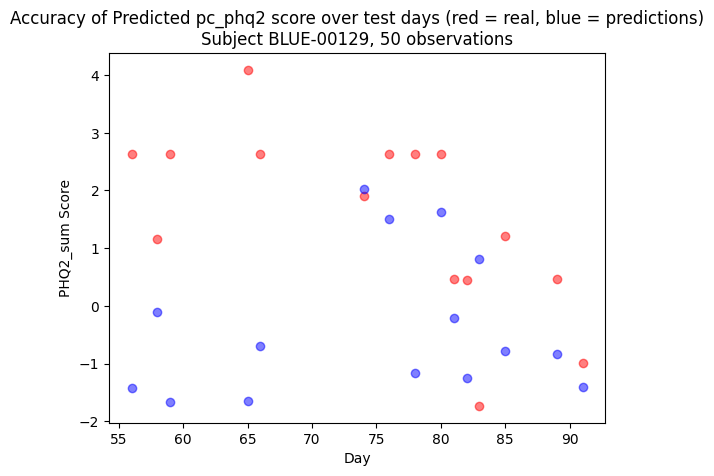

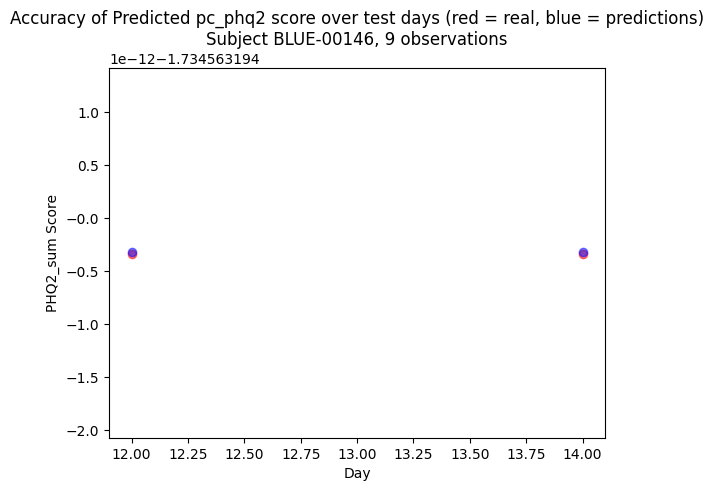

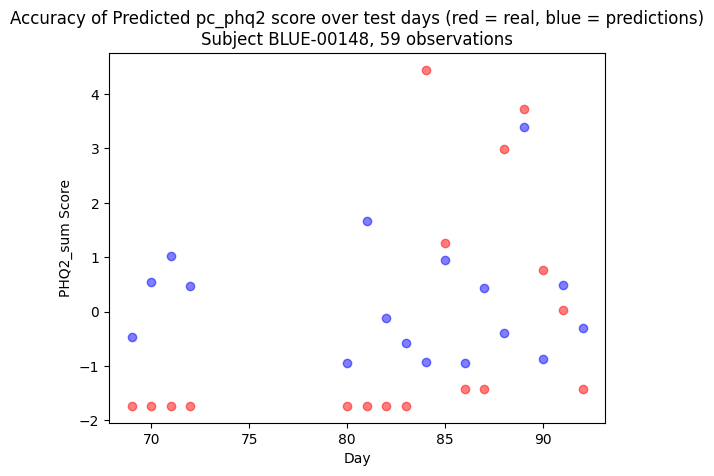

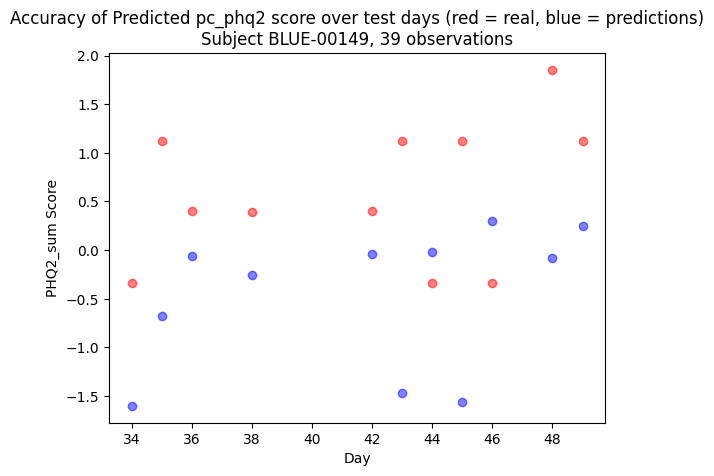

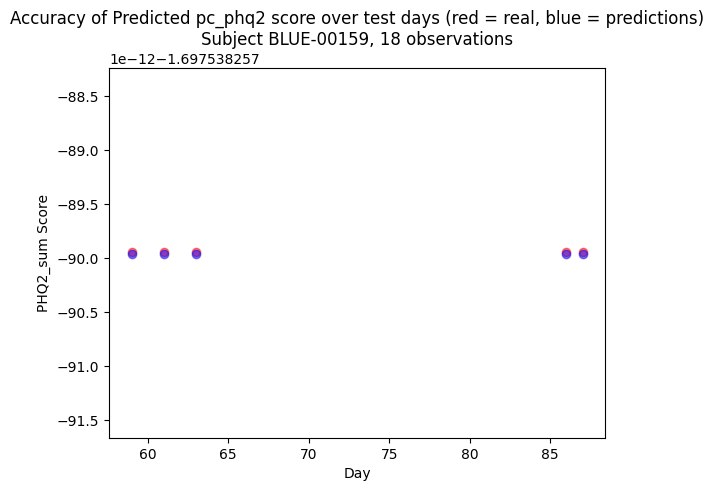

In [ ]:
####### Try RF Walk-forward validation on individual subjects
# Define y col and the data
y_var = 'pc_depression'
data = pd.read_csv(os.path.join(brighten_dir, 'v1_day_pca.csv'))
results = pd.DataFrame()
count=0
x_cols = [col for col in data.columns.to_list() if 'pc_' in col and col!=y_var]
y_col = [y_var]
num_subjects_to_test =  10


# Define what x columns will go into the model
all_cols = ['num_id', 'day'] + x_cols + y_col
rf_v1 = data[all_cols]

# Drop any participants with NA data in those x-cols
#print('pre dropna', rf_v1.shape)
rf_v1 = rf_v1.dropna()
#print('post dropna', rf_v1.shape)

# Go through each participant
for id in rf_v1['num_id'].unique():
    if count <= num_subjects_to_test:
        sub_df = rf_v1[rf_v1['num_id'] == id]
        sub_df = sub_df.sort_values('day')
        
        # If particpant has 8+ entries, run the RF model on them
        if sub_df.shape[0] > 8:
            #print(sub_df)
            # Define test percentage
            test_prc = 0.3

            # Calculate number of rows used for testing vs. for training
            rows = sub_df.shape[0]
            n_test = int(rows * test_prc)

            # Extract the days of the test set, by taking all dates n_test from the end
            sub_df = sub_df.set_index('day')
            test_dates = sub_df.index[-n_test:]
            
            #print(test_dates)

            # Do RF after dropping day and participant ID 
            sub_df_clean = sub_df.drop(['num_id'], axis=1)
            #print('columns:', sub_df_clean.columns.tolist())
            mae, test_y, rf_predictions, rmse, r2 = mod.walk_forward_validation(sub_df_clean, 0.3, verbose=False)
            
                
            # Step 3: Create DataFrame for easy merging
            sub_results = pd.DataFrame({
                'subject_id': [id],
                'r-squared': [r2],
                'mae': [mae],
                'rmse': [rmse]
            })
            results = pd.concat([results, sub_results], ignore_index=True)
            
            count+=1
            
            # Scatterplot expected and predicted for each day
            plt.scatter(test_dates,test_y, color='red',marker='o', alpha=0.5)
            plt.scatter(test_dates, rf_predictions, color='blue',marker='o', alpha=0.5)
            plt.xlabel('Day')
            plt.ylabel('PHQ2_sum Score')
            plt.title(f'Accuracy of Predicted pc_phq2 score over test days (red = real, blue = predictions)\nSubject {id}, {sub_df.shape[0]} observations')
            plt.show()


            # # lineplot expected vs predicted
            # plt.figure(figsize=(5,2))
            # plt.plot(rf_predictions, label='Predicted')
            # plt.plot(test_y, label='Expected')
            # plt.title(f'Accuracy of Predicted PHQ2_SUM score over test days\nSubject {id}, {sub_df.shape[0]} observations')
            # plt.legend()
            # plt.show()

In [ ]:
########### Running multivariate stacked walk-forward validation on all subjects ###########
# Define y col and the data
y_var = 'pc_depression_phq2'
data = pd.read_csv(os.path.join(brighten_dir, 'v1_day_pca.csv'))
x_cols = [col for col in data.columns.to_list() if 'pc_' in col and col!=y_var]
all_cols = ['num_id', 'day'] + x_cols + [y_var]
rf_data = data[all_cols]


# Drop any participants with NA data in those x-cols
print('pre dropna', rf_data.shape)
rf_data = rf_data.dropna()
print('post dropna', rf_data.shape)

# Take out val percentage
test_prc = 0.3
# Calculate number of rows used for testing vs. for training
rows = rf_data.shape[0]
val_prc = 0.15
n_val = int(rows * val_prc)
print('Rows of validation data:', n_val)
val_dates = rf_data.index[-n_val:]
val_rows = rf_data.iloc[val_dates]
print(val_rows.shape)
# Take val dates out of the training data
rf_data = rf_data.drop(val_dates)
print('post val drop', rf_data.shape)


# Do RF after dropping day and participant ID 
rf_clean = rf_data.drop(['num_id'], axis=1)
#print('columns:', sub_df_clean.columns.tolist())
mae, test_y, rf_predictions, rmse, r2 = mod.walk_forward_validation(rf_clean, 0.3, verbose=True)

# Step 3: Create DataFrame for easy merging
rf_results = pd.DataFrame({
    'r-squared': [r2],
    'mae': [mae],
    'rmse': [rmse]
})

print(rf_results)


pre dropna (7532, 6)
post dropna (7532, 6)
Rows of validation data: 1129
(1129, 6)
   r-squared       mae      rmse
0   0.059783  1.313199  2.609114


NameError: name 'test_dates' is not defined

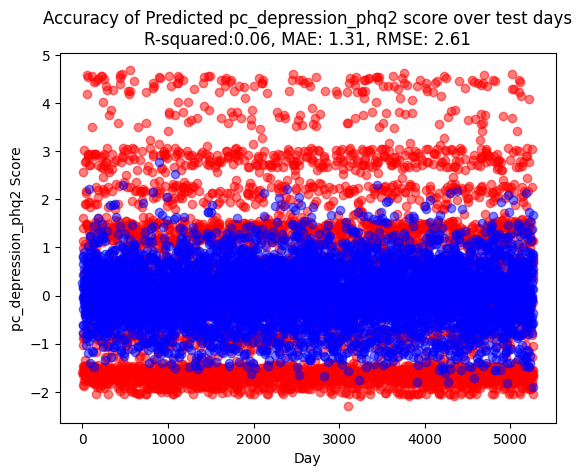

In [ ]:
# Scatterplot expected and predicted for each day

import numpy as np
test_days = np.arange(0, 5272)

plt.scatter(test_days, test_y, color='red',marker='o', alpha=0.5)
plt.scatter(test_days, np.array(rf_predictions), color='blue',marker='o', alpha=0.5)
plt.xlabel('Day')
plt.ylabel(f'{y_var} Score')
plt.title(f'Accuracy of Predicted {y_var} score over test days\nR-squared:{rf_results['r-squared'][0]:.2f}, MAE: {rf_results['mae'][0]:.2f}, RMSE: {rf_results['rmse'][0]:.2f}')
plt.show()



['aggregate_communication_scaled_int', 'call_count_scaled_int', 'call_duration_scaled_int', 'interaction_diversity_scaled_int', 'missed_interactions_scaled_int', 'mobility_scaled_int', 'mobility_radius_scaled_int', 'sms_count_scaled_int', 'sms_length_scaled_int', 'unreturned_calls_scaled_int']
Validation Results:
MAE: 0.8526027397260273, RMSE: 1.0875314512850867, R2: -0.09114731876217275


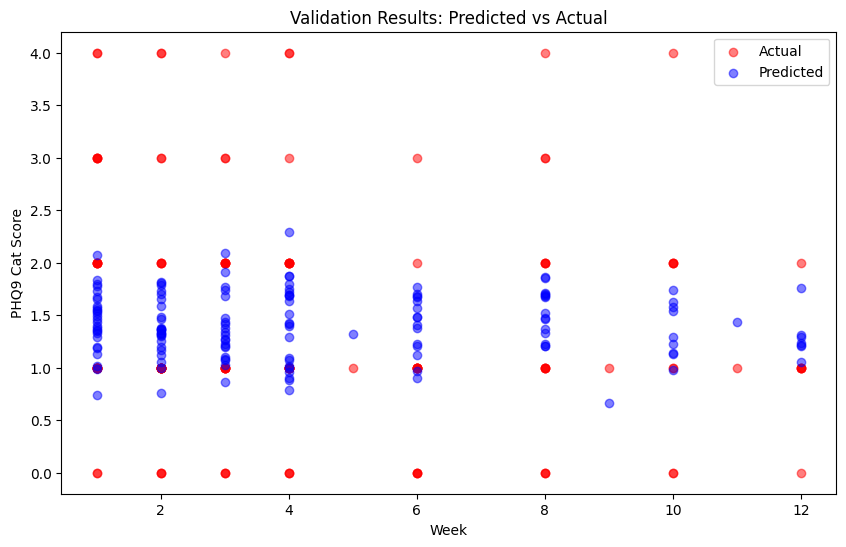

In [ ]:
# Do Random Forest Regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Step 1: Define your X (features) and y (target) for training and validation
# Remove 'num_id' and 'day' from val_rows for predictions
# Define y col and the data
y_var = 'pc_depression'

for name, df in dfs_scaled.items():
    data = pd.read_csv(os.path.join(brighten_dir, f'{name}_pca.csv'))
    x_cols = [col for col in data.columns.to_list() if 'pc_' in col and col!=y_var]
    y_col = [y_var]
    all_cols = ['num_id', 'day'] + x_cols + y_col

    # Take out val percentage
    val_prc = 0.15
    n_val = int(data.shape[0] * val_prc) # Number of val rows
    val_dates = data.index[-n_val:] # Define val indexes
    val_df = data.iloc[val_dates] # Drop those indexes
    val_x = val_df[x_cols]
    val_y = val_df[y_var]

    # Traintest df taking out val
    traintest_df = data.drop(val_dates)

    # Training data for the random forest
    train_x = traintest_df[x_cols]
    train_y = traintest_df[y_var]

    # Step 2: Train the Random Forest model
    rf_model = RandomForestRegressor(random_state=42)
    rf_model.fit(train_x, train_y.values.ravel())  # Flatten y for sklearn compatibility

    # Step 3: Apply the model to validation data
    val_predictions = rf_model.predict(val_x)

    # Step 4: Evaluate the performance on validation rows
    val_mae = mean_absolute_error(val_y, val_predictions)
    val_rmse = np.sqrt(mean_squared_error(val_y, val_predictions))
    val_r2 = r2_score(val_y, val_predictions)

    print(f"Validation Results:\nMAE: {val_mae}, RMSE: {val_rmse}, R2: {val_r2}")

    # Step 5: Create a scatterplot for validation data
    plt.figure(figsize=(10, 6))
    plt.scatter(val_df['week'], val_y, color='red', marker='o', alpha=0.5, label='Actual')
    plt.scatter(val_df['week'], val_predictions, color='blue', marker='o', alpha=0.5, label='Predicted')
    plt.xlabel('Week')
    plt.ylabel('pc_depression Score')
    plt.title(f'RF Regressor Model predicting {y_var} in {name}')
    plt.suptitle(f'Mean Absolute Error: {val_mae:.2f}; R2 Score: {val_r2:.2f}')
    plt.legend()
    plt.show()

['aggregate_communication_scaled_int', 'call_count_scaled_int', 'call_duration_scaled_int', 'interaction_diversity_scaled_int', 'missed_interactions_scaled_int', 'mobility_scaled_int', 'mobility_radius_scaled_int', 'sms_count_scaled_int', 'sms_length_scaled_int', 'unreturned_calls_scaled_int']
(977, 28)
(831, 28)
Validation Results:
MAE: 0.9178082191780822, RMSE: 1.3085598064755342, R2: -0.5797446440164467


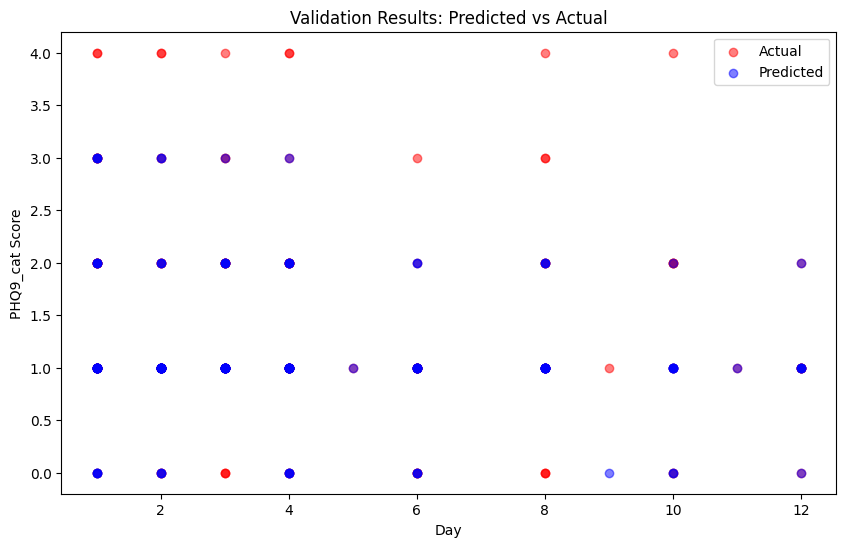

In [ ]:
######## Running classifier instead of regressor ##########
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Step 1: Define your X (features) and y (target) for training and validation
# Remove 'num_id' and 'day' from val_rows for predictions
# Define y col and the data
data = pd.read_csv(os.path.join(brighten_dir, 'v1_week_pca_.csv'))
y_var = ['phq9_cat']
id_columns_short = ['num_id','num_id','week']
x_cols = [col for col in data.columns if 'pc_' not in col and 'phq9' not in col and col not in id_columns_short]
print(x_cols)

# Take out val percentage
val_prc = 0.15
n_val = int(data.shape[0] * val_prc) # Number of val rows
val_dates = data.index[-n_val:] # Define val indexes
val_df = data.iloc[val_dates] # Drop those indexes
val_x = val_df[x_cols]
val_y = val_df[y_var]

# Traintest df taking out val
traintest_df = data.drop(val_dates)

# Training data for the random forest
train_x = traintest_df[x_cols]
train_y = traintest_df[y_var]

# Step 2: Train the Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(train_x, train_y.values.ravel())  # Flatten y for sklearn compatibility

# Step 3: Apply the model to validation data
val_predictions = rf_model.predict(val_x)

# Step 4: Evaluate the performance on validation rows
val_mae = mean_absolute_error(val_y, val_predictions)
val_rmse = np.sqrt(mean_squared_error(val_y, val_predictions))
val_r2 = r2_score(val_y, val_predictions)

print(f"Validation Results:\nMAE: {val_mae}, RMSE: {val_rmse}, R2: {val_r2}")

# Step 5: Create a scatterplot for validation data
plt.figure(figsize=(10, 6))
plt.scatter(val_df['week'], val_y, color='red', marker='o', alpha=0.5, label='Actual')
plt.scatter(val_df['week'], val_predictions, color='blue', marker='o', alpha=0.5, label='Predicted')
plt.xlabel('Day')
plt.ylabel('PHQ9_cat Score')
plt.title('Validation Results: Predicted vs Actual')
plt.legend()
plt.show()